In [1]:
import csv
import os

import mrimotion as mot
import mghGErecon as ge
import multicoil_motion_simulator
import numpy as np
import plotting_utils
from scipy import ndimage
from matplotlib import pyplot as plt

In [2]:
scan_dir = '/vast/kmotion/users/nmsingh/dev/ismrm2022/multicoil_data_splits_obofix'
scan_list_path = os.path.join(scan_dir,'test.csv')

acq_paths = []
with open(scan_list_path, 'r') as f:
    reader = csv.reader(f)
    for row in reader:
        acq_paths.append(row[0])
 

In [3]:
acq_path = acq_paths[4]

recon_data_path = os.path.join(acq_path,'kspace_recon.npz')
kspace = mot.utils.load_kspace(recon_data_path, 'ge', z_shift=False)

file only has one key: kspace_recon
  return numpy array
no kz pi phase shift applied
loaded k-space size is: (416, 300, 44, 30)


In [4]:
acq_data_path = os.path.join(acq_path,'kspace_acquired.npz')
acq_kspace = np.load(acq_data_path)['kspace_acquired'][:,:,6,:44,0,1]

In [5]:
acq_kspace.shape

(416, 300, 44)

In [6]:
kspace_sl = kspace[:,:,:44,13]
k = kspace_sl[...,np.newaxis].transpose(0,1,3,2)
maps = mot.coilsens.run_espirit(k, auto_calib=True)

--- running ESPIRIT ----
   found 44 channels    
   CHECK ^^             
------------------------
ESPIRIT: using -a automatic threshold setting
  this could take ~10 min...
ESPIRIT done (62.59 s)


In [7]:
res_info = np.load(os.path.join(acq_path,'resolutioninfo.npz'))
psx = res_info['pixelSizeX']
psy = res_info['pixelSizeY']

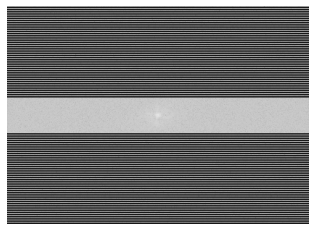

In [8]:
plotting_utils.plot_k(acq_kspace)

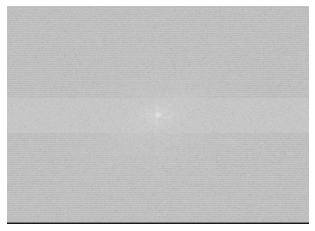

In [9]:
plotting_utils.plot_k(kspace_sl)

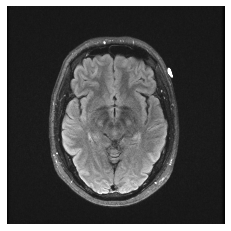

In [10]:
plotting_utils.plot_img_from_k(kspace_sl,psx=psx,psy=psy,vmin=0,vmax=10000)

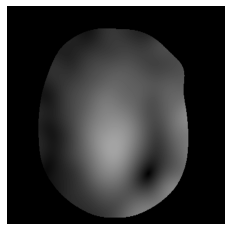

In [11]:
plotting_utils.plot_img(np.fft.fftshift(maps[:,:,:,40],axes=(0,1)),psx=psx,psy=psy,vmin=0,vmax=1e-1)

Number of:
  current_y_res = 300, ref_views = 0 
  slices = 30 
  operations = 1 
  passes = 2
pass 0:
 15 slices per TR: [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28]
 segments: 8
pass 1:
 15 slices per TR: [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]
 segments: 8


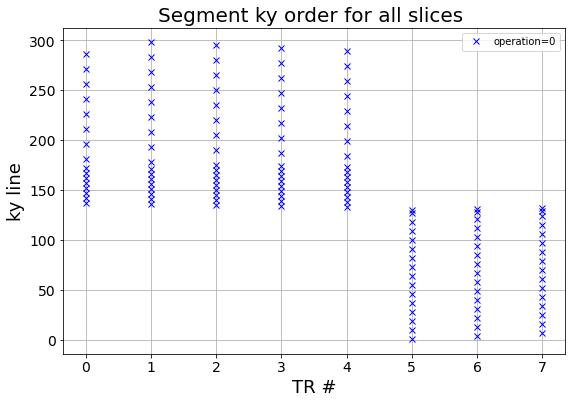

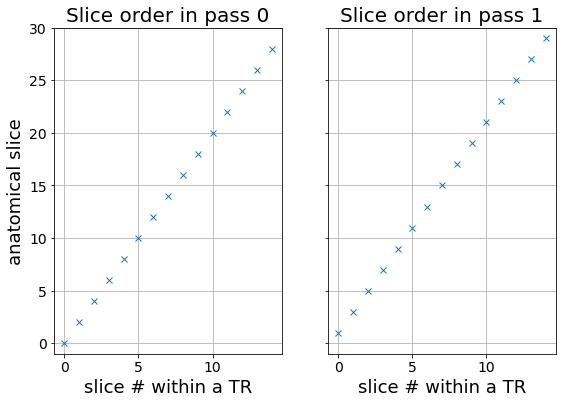

In [12]:
file_2d_acqorder = os.path.join(acq_path, 'loopcounters.npz')
order_ky, _, _ = mot.acqorder.get_segments(file_2d_acqorder, show_plots=True)
order_ky = [order.astype('int32')-1 for order in order_ky]

In [13]:
maps = maps[:,:,0,:]

In [14]:
kspace = k[:,:,0,:]

kspace_shift = np.fft.ifftshift(kspace,axes=(0,1))
img_slice = np.fft.fftshift(np.fft.ifftn(kspace_shift,axes=(0,1)),axes=(0,1))
img_recon = np.sqrt(np.sum(np.square(np.abs(img_slice)), axis=2))

n_x = kspace.shape[1]
n_y = kspace.shape[0]

num_motions = 1
motion_shots = [0]
motion_shots.extend(np.sort(np.random.randint(1,len(order_ky),size=num_motions)))
num_points = len(motion_shots)

num_pix = np.zeros((num_points, 2))
angle = np.zeros(num_points)

max_htrans = 0.03
max_vtrans = 0.03
max_rot = 0.03

max_htrans_pix = n_x * max_htrans
max_vtrans_pix = n_y * max_vtrans
max_rot_deg = 360 * max_rot

num_pix[:, 0] = np.random.random(
    num_points) * (2 * max_htrans_pix) - max_htrans_pix
num_pix[:, 1] = np.random.random(
    num_points) * (2 * max_vtrans_pix) - max_vtrans_pix
angle = np.random.random(num_points) * \
    (2 * max_rot_deg) - max_rot_deg

sl = img_recon
n = sl.shape[1]
sl_k_true = multicoil_motion_simulator.simulate_multicoil_k(sl, maps)
sl_k_combined = np.zeros(sl_k_true.shape, dtype='complex64')

for i in range(len(motion_shots)):
    if(i!=len(motion_shots)-1):
        shots = range(motion_shots[i],motion_shots[i+1])
    else:
        shots = range(motion_shots[i],len(order_ky))

    for shot in shots:
        sl_rotate = ndimage.rotate(sl, angle[i], reshape=False, mode='nearest')

        if(len(num_pix.shape) == 1):
            sl_moved = ndimage.interpolation.shift(
                sl_rotate, [0, num_pix[i]], mode='nearest')
        elif(num_pix.shape[1] == 2):
            sl_moved = ndimage.interpolation.shift(
                sl_rotate, [0, num_pix[i, 0]])
            sl_moved = ndimage.interpolation.shift(
                sl_moved, [num_pix[i, 1], 0])

        sl_k_after = multicoil_motion_simulator.simulate_multicoil_k(sl_moved,maps)
        sl_k_combined[:,order_ky[shot],:] = sl_k_after[:,order_ky[shot],:]

        if(int(n/2) in order_ky[shot]):
            sl_k_true = sl_k_after

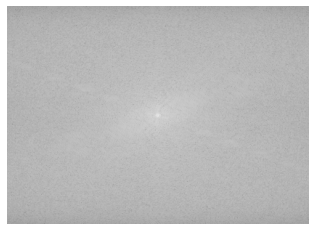

In [15]:
plotting_utils.plot_k(sl_k_after)

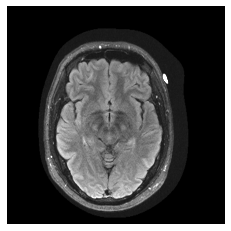

In [16]:
plotting_utils.plot_img_from_k(sl_k_after,psx=psx,psy=psy,vmin=0,vmax=10000)

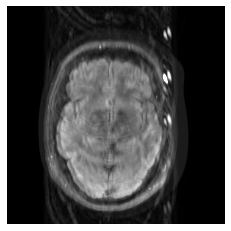

In [17]:
plotting_utils.plot_img_from_k(sl_k_combined,psx=psx,psy=psy,vmin=0,vmax=10000)

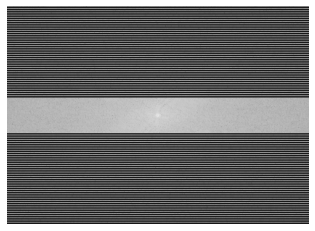

In [18]:
plotting_utils.plot_k(sl_k_combined)

In [29]:
print(np.abs(sl_k_combined[0,:,0])>0)

[ True False False  True False False  True False False  True False False
  True False False  True False False  True False False  True False False
  True False False  True False False  True False False  True False False
  True False False  True False False  True False False  True False False
  True False False  True False False  True False False  True False False
  True False False  True False False  True False False  True False False
  True False False  True False False  True False False  True False False
  True False False  True False False  True False False  True False False
  True False False  True False False  True False False  True False False
  True False False  True False False  True False False  True False False
  True False False  True False False  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  T

In [19]:
sl_k_combined.shape

(416, 300, 44)

In [20]:
np.max(np.abs(sl_k_combined))

48347440.0

In [21]:
grappa_sl_k_combined = ge.recon.recon_arc_kspace(sl_k_combined, acq_path)

running ARC recon, input dims: (416, 300, 44)
psdnameannot:  
psd_iname: FSE
psdname: fse-xl
pseq: 19.0
se_desc: ANONYMIZED
 ----
 sequence is 2DFSE 
 ----
target of GERecon.so symlink is:
	/vast/kmotion/code/ge-orchestra/orchestra-sdk-1.10-1/orchestra-sdk-1.10-1.python/GERecon.so.python35
orchestra_version: 	orchestra-sdk-1.10-1.python
gerecon_version: 	GERecon.so.python35
  running ARC on slice: 0


In [22]:
grappa_sl_k_combined.shape

(416, 300, 44)

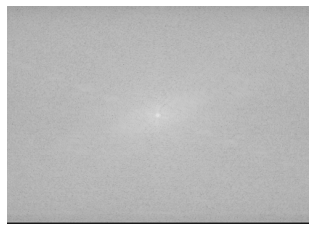

In [23]:
plotting_utils.plot_k(grappa_sl_k_combined)

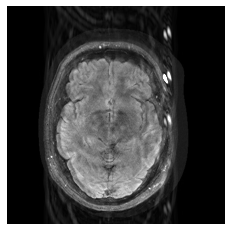

In [24]:
plotting_utils.plot_img_from_k(grappa_sl_k_combined,psx=psx,psy=psy,vmin=0,vmax=10000)

In [25]:
np.savez('test_example.npz',sl_k_combined=sl_k_combined,sl_k_true=sl_k_true,grappa_sl_k_combined=grappa_sl_k_combined,psx=psx,psy=psy)